# Pyramid Transfomer
## 객체 감지
### multiple classes

### 사용 데이터
### caltech101


In [1]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 42.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
downloaded_file = keras.utils.get_file(fname="caltech_101_zipped",origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",extract=True, archive_format="zip",  cache_dir="/",)

137414764/137414764 [==============================] - 19s 0us/step


In [4]:
shutil.unpack_archive("/datasets/caltech-101/101_ObjectCategories.tar.gz", "/")
shutil.unpack_archive("/datasets/caltech-101/Annotations.tar", "/")

In [5]:
image_paths = [f for f in os.listdir("/101_ObjectCategories/crocodile_head/") if os.path.isfile(os.path.join("/101_ObjectCategories/crocodile_head/", f))]
annot_paths = [f for f in os.listdir("/Annotations/crocodile_head/") if os.path.isfile(os.path.join("/Annotations/crocodile_head/", f))]

image_paths.sort()
annot_paths.sort()

image_size = 224

In [6]:
annot_paths

['annotation_0001.mat',
 'annotation_0002.mat',
 'annotation_0003.mat',
 'annotation_0004.mat',
 'annotation_0005.mat',
 'annotation_0006.mat',
 'annotation_0007.mat',
 'annotation_0008.mat',
 'annotation_0009.mat',
 'annotation_0010.mat',
 'annotation_0011.mat',
 'annotation_0012.mat',
 'annotation_0013.mat',
 'annotation_0014.mat',
 'annotation_0015.mat',
 'annotation_0016.mat',
 'annotation_0017.mat',
 'annotation_0018.mat',
 'annotation_0019.mat',
 'annotation_0020.mat',
 'annotation_0021.mat',
 'annotation_0022.mat',
 'annotation_0023.mat',
 'annotation_0024.mat',
 'annotation_0025.mat',
 'annotation_0026.mat',
 'annotation_0027.mat',
 'annotation_0028.mat',
 'annotation_0029.mat',
 'annotation_0030.mat',
 'annotation_0031.mat',
 'annotation_0032.mat',
 'annotation_0033.mat',
 'annotation_0034.mat',
 'annotation_0035.mat',
 'annotation_0036.mat',
 'annotation_0037.mat',
 'annotation_0038.mat',
 'annotation_0039.mat',
 'annotation_0040.mat',
 'annotation_0041.mat',
 'annotation_004

In [7]:
images, targets = [], []
# Annotations 주석
for i in range(0, len(annot_paths)):
    annot = scipy.io.loadmat("/Annotations/crocodile_head/" + annot_paths[i])["box_coord"][0]
    ##  box에 대한 점위치또한 저장
    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = keras.utils.load_img(
        "/101_ObjectCategories/crocodile_head/" + image_paths[i],
    )
    (w, h) = image.size[:2]
    ## 각 image resize
    if i < int(len(annot_paths) * 0.8):
        image = image.resize((image_size, image_size))

    images.append(keras.utils.img_to_array(image))
    ## 4각 형 길이도 target저장
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

In [8]:
images[0].shape

(224, 224, 3)

In [9]:
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

<ipython-input-9-6c66826c3338>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8) :]),


In [10]:
x_train[0].shape

(224, 224, 3)

### pyramid transformer의 약간의 변화

In [11]:
input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
projection_dim = 64
num_heads = 4
patch_size = 32
## units 설정할수도있
# transformers_units = [projection_dim,projection_dim*2]
history = []
num_patches = (image_size // patch_size) ** 2

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        ## get_config정의되어있음,  input_shaep 저장
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_layers": 1,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])


In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": 32,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_layers": 1,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## 가장 중요한 부분
### 이전의 patch는 이전에서 사용한 거의 그대로 사용

In [14]:
inputs = layers.Input(shape=input_shape)
# Create patches
patches = Patches(32)(inputs)
# Encode patches
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

## Layer Normalization
x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
# Create a multi-head attention layer.
## 똑같이 MultiheadAttention
attention_output = layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=projection_dim, dropout=0.1
)(x1, x1)
# Skip connection 1.
x2 = layers.Add()([attention_output, encoded_patches])
# Layer normalization 2.
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
# MLP
x3 = layers.Dense(128, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.Dense(64, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
# Skip connection 2.
encoded_patches = layers.Add()([x3, x2])

# Create a [batch_size, projection_dim] tensor.
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.3)(representation)

features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.3)(features)
features = layers.Dense(1024, activation=tf.nn.gelu)(features)
features = layers.Dropout(0.3)(features)
features = layers.Dense(512, activation=tf.nn.gelu)(features)
features = layers.Dropout(0.3)(features)
features = layers.Dense(64, activation=tf.nn.gelu)(features)
features = layers.Dropout(0.3)(features)
features = layers.Dense(32, activation=tf.nn.gelu)(features)
features = layers.Dropout(0.3)(features)
## 앞선 box의 4위치 기억
bounding_box = layers.Dense(4)(
    features
)  # Final four neurons that output bounding box

model = keras.Model(inputs=inputs, outputs=bounding_box)

In [22]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs,validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.1756 - val_loss: 0.0762
Epoch 2/50
1/1 [==============================] - 0s 55ms/step - loss: 0.1589 - val_loss: 0.1392
Epoch 3/50
1/1 [==============================] - 0s 51ms/step - loss: 0.1525 - val_loss: 0.0355
Epoch 4/50
1/1 [==============================] - 0s 55ms/step - loss: 0.1920 - val_loss: 0.0689
Epoch 5/50
1/1 [==============================] - 0s 56ms/step - loss: 0.1304 - val_loss: 0.0830
Epoch 6/50
1/1 [==============================] - 0s 53ms/step - loss: 0.2009 - val_loss: 0.0760
Epoch 7/50
1/1 [==============================] - 0s 58ms/step - loss: 0.1462 - val_loss: 0.0576
Epoch 8/50
1/1 [==============================] - 0s 58ms/step - loss: 0.1447 - val_loss: 0.0622
Epoch 9/50
1/1 [==============================] - 0s 55ms/step - loss: 0.1610 - val_loss: 0.0557
Epoch 10/50
1/1 [==============================] - 0s 54ms/step - loss: 0.1403 - val_loss: 0.0646
Epoch 11/50
1/1 [==============

1/1 [==============================] - 0s 25ms/step
mean_iou: 0.6187313994092366


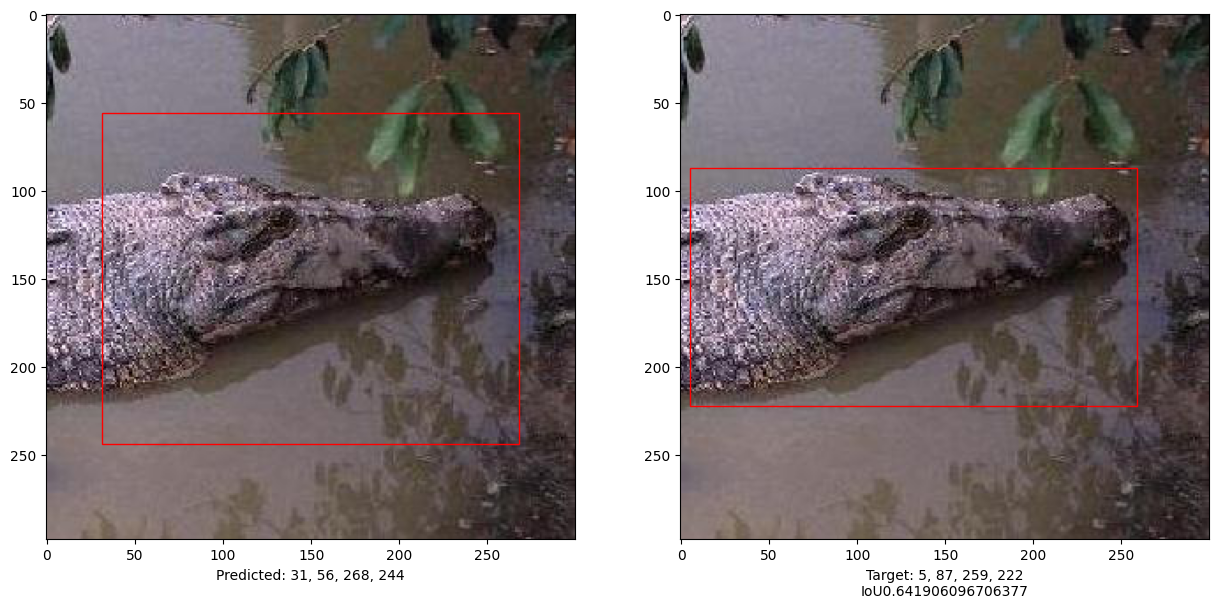

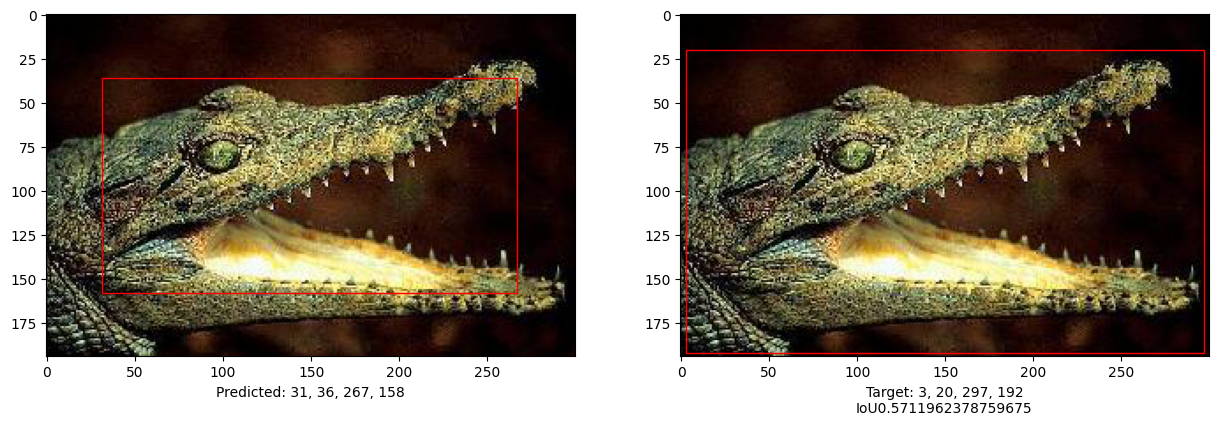

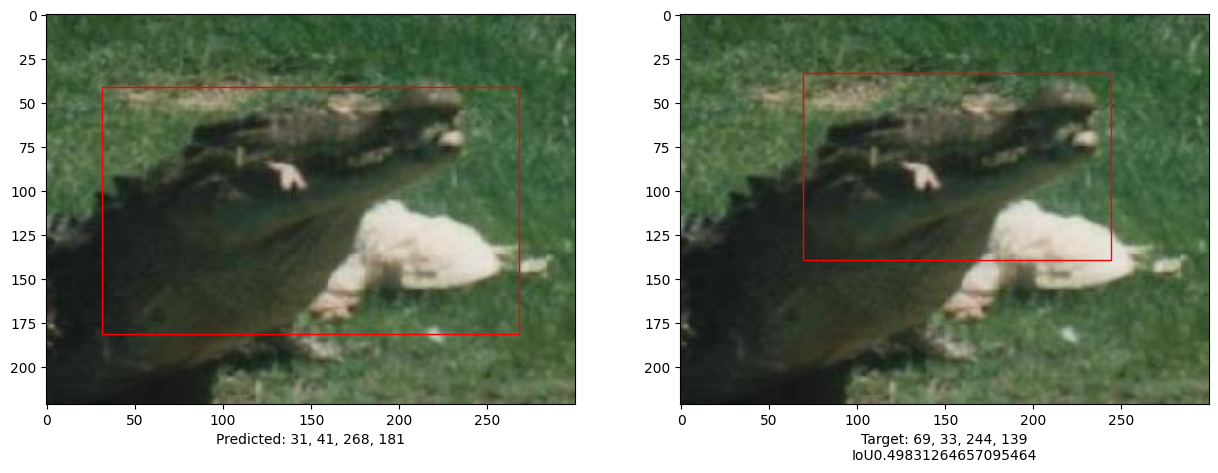

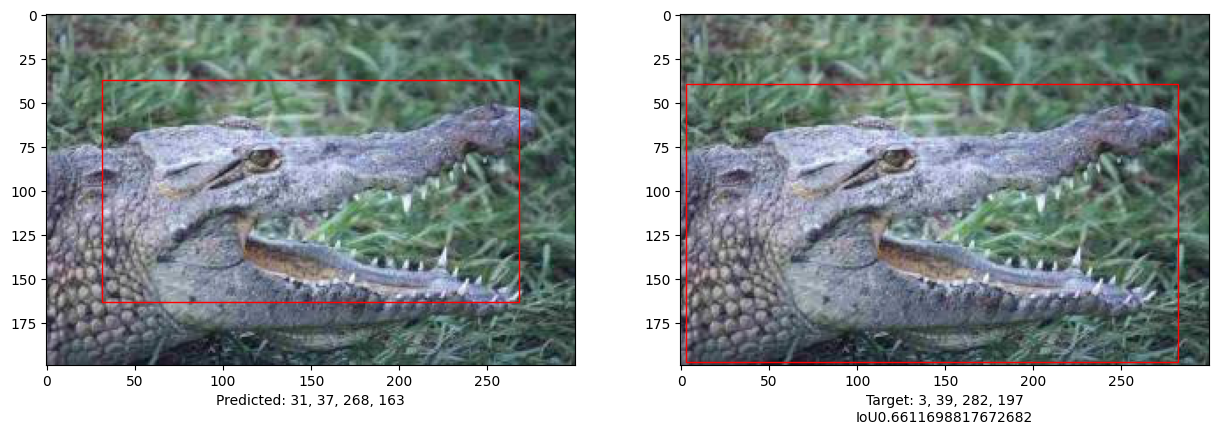

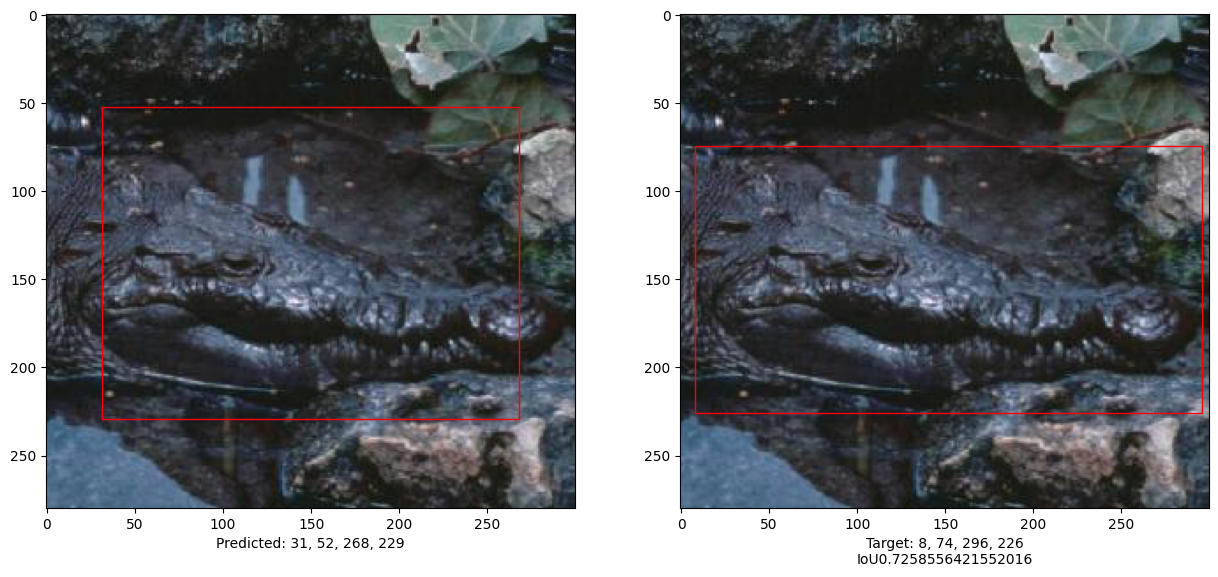

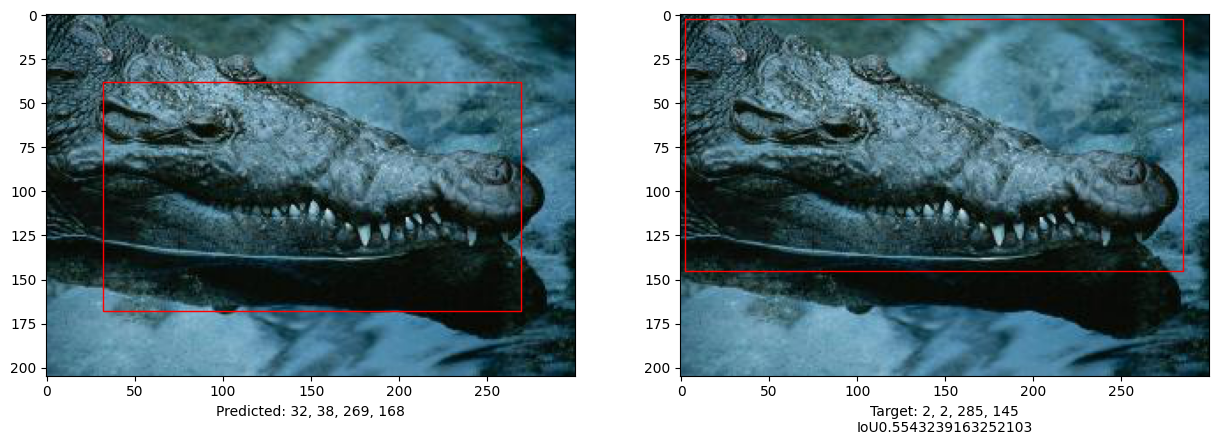

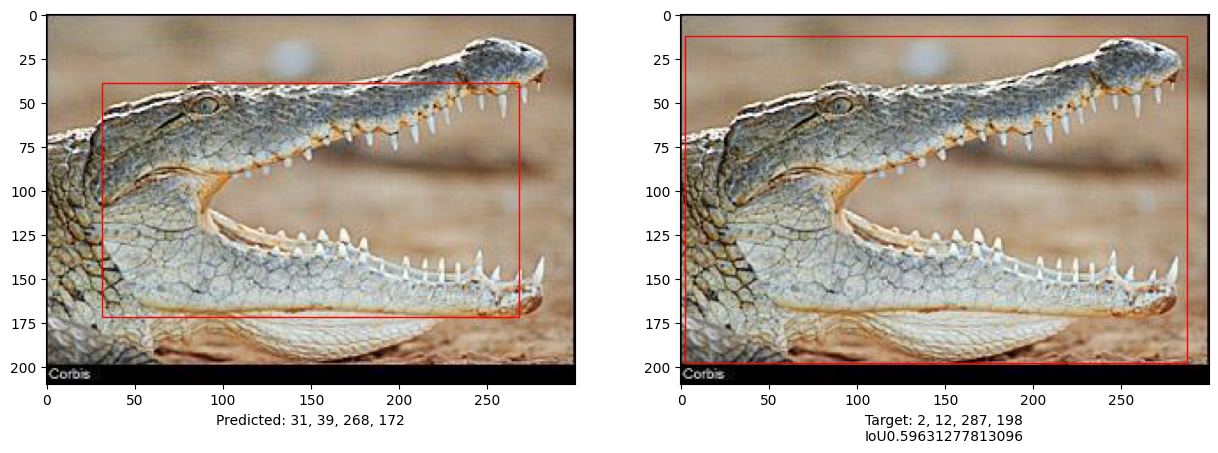

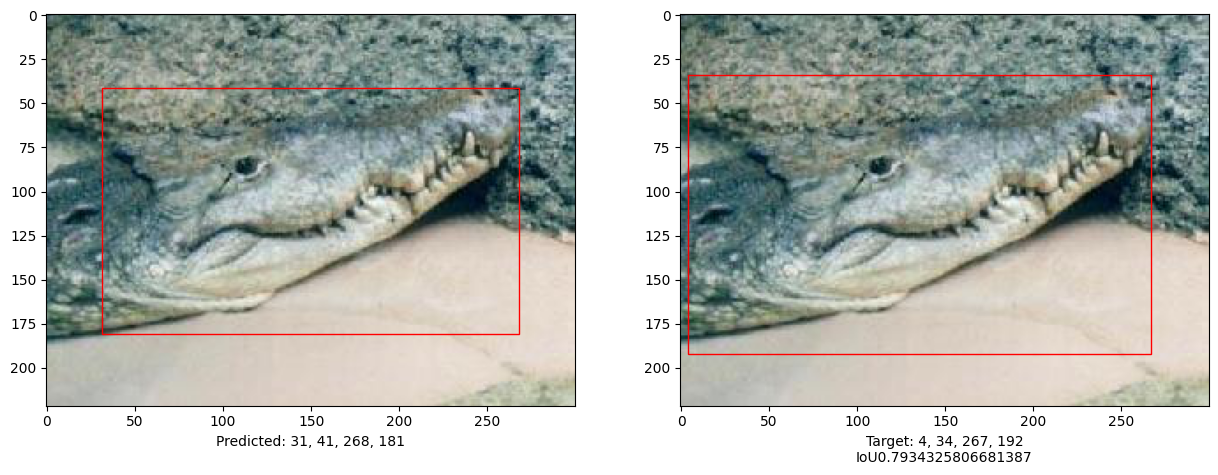

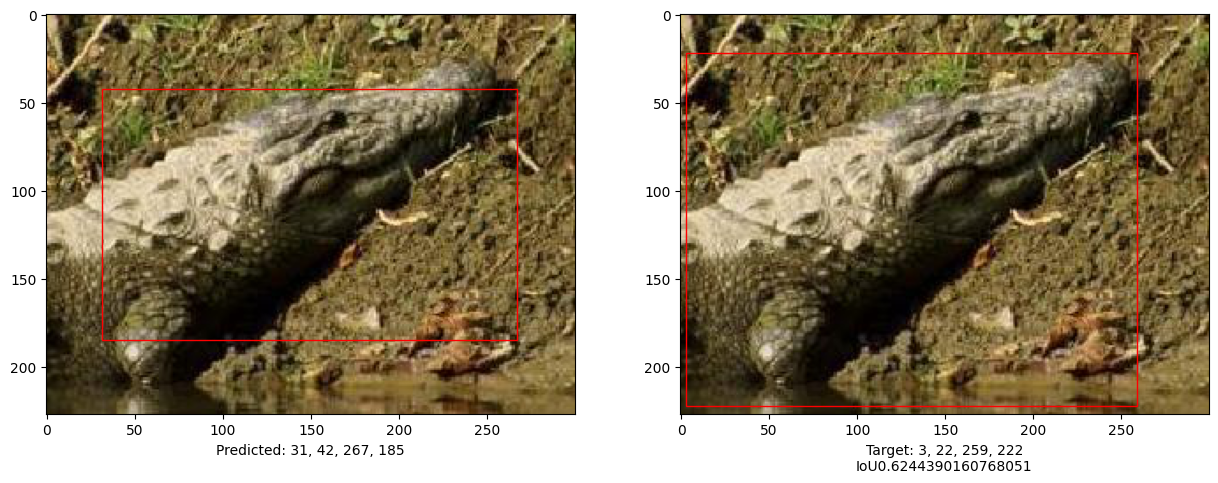

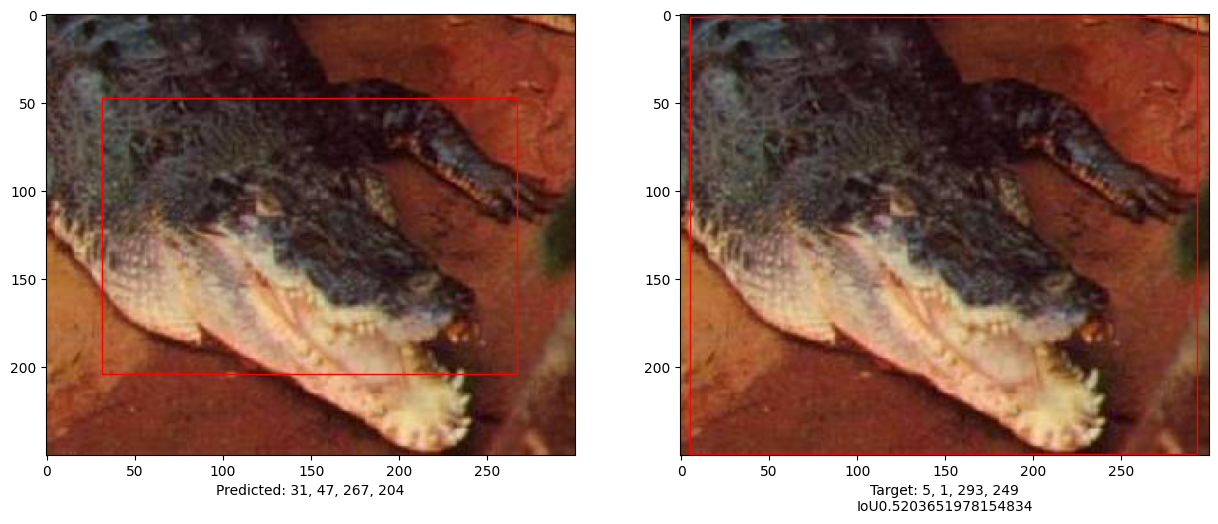

In [23]:
import matplotlib.patches as patches

# Saves the model in current path
model.save("PT.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    ## model에 의해 여러 출력값이 나오기 때문에
    ## 합에 대한 교집합 공식 사용해야함
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    ## 예측
    preds = model.predict(input_image)[0]

    (h, w) = (im).shape[0:2]
    # model의 예측 # type을 각각 가로세로 길이 높이로 곱해줌
    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)
    # model의 bottom도 다 구해줌
    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

In [25]:
preds


array([0.10408166, 0.18890423, 0.8922698 , 0.8191776 ], dtype=float32)